In [202]:
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
from pylab import rcParams
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format = 'svg' # quality 

rcParams['figure.figsize'] = 5,5
sns.set_style("darkgrid")

In [203]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [204]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Firstly,let's deal with categorical variables:
* Name
* Sex
* Ticket 
* Cabin 
* Embarked
* Pclass

### Categorical Features Visualization

In [205]:
def visualise(feature):
    survived = train_data[train_data['Survived'] == 1][feature].value_counts()
    died = train_data[train_data['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived,died])
    df.index = ['Survived','Died']
    df.plot(kind='bar',stacked=True,figsize=(10,5))

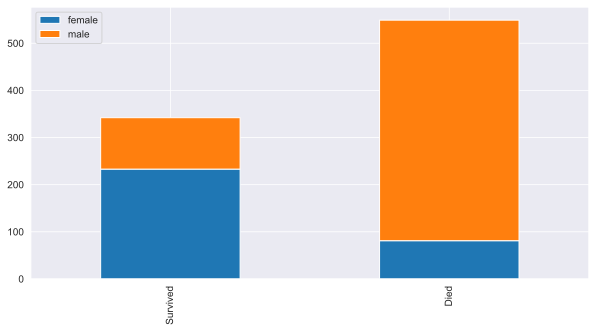

In [206]:
visualise('Sex')

Can notice that most of people who died were men. Hence, Sex is a good feature for prediction

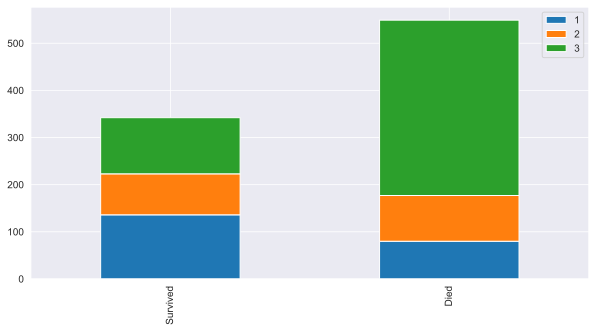

In [207]:
visualise('Pclass')

If you are rich,probably you will survive..hmmm.Also a good feature.

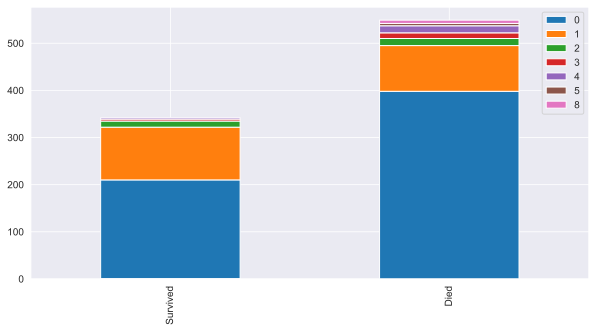

In [208]:
visualise('SibSp')

Having a family is also a good feature. if you have relatives you have more chances to survive.

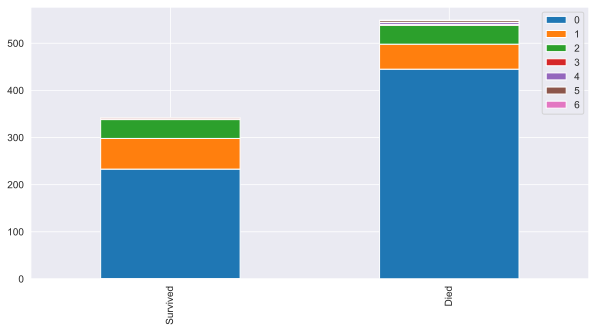

In [209]:
visualise('Parch')

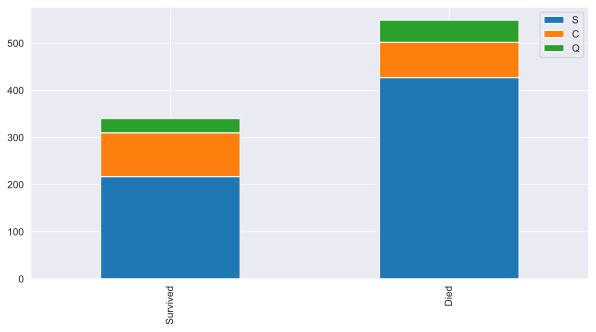

In [210]:
visualise('Embarked')

### Feature Selection

### Name Encoding

In [211]:
merged_data = [train_data, test_data]

for dataset in merged_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

In [212]:
train_data['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Jonkheer      1
Ms            1
Countess      1
Capt          1
Mme           1
Don           1
Sir           1
Lady          1
Name: Title, dtype: int64

In [213]:
"""
In order not to write all titles manually we will create set (to obtain only unique titles)
Then we will create a dictionary to encode the titles
Finally,apply map function to encode the titles in datasets

"""

titles_set = set([])
title_map = {}

for idx in range(len(merged_data)):
    for title in merged_data[idx]['Title']:
        titles_set.add(title)

for title in list(titles_set):
    if title == 'Mr':
        title_map[title] = 0
    elif title == 'Miss':
        title_map[title] = 1
    elif title == 'Mrs':
        title_map[title] = 2
    else:
        title_map[title] = 3
        
for idx in merged_data:
    idx['Title'] = idx['Title'].map(title_map)

We have successfully encoded the titles:
* Mr = 0
* Miss = 1
* Mrs = 2
* Others = 3

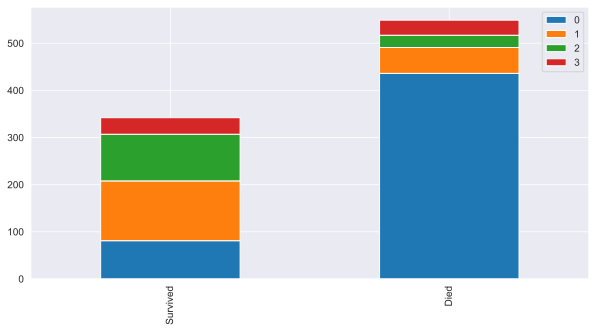

In [215]:
visualise('Title')

Can observe that again Women are more likely to survive rather than men. Kepp that and drop name columns because we don't need them any more

In [216]:
train_data.drop('Name',axis=1,inplace=True)
test_data.drop('Name',axis=1,inplace=True)

### Gender Encoding

In [217]:
gender_map = {'male':0,'female':1}

for idx in merged_data:
    idx['Sex'] = idx['Sex'].map(gender_map)

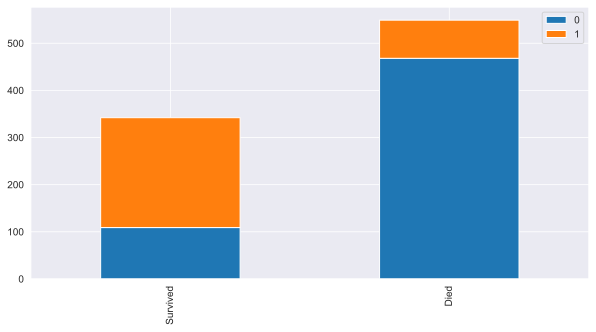

In [218]:
visualise('Sex')

### Age Encoding

Instead of using avg of whole column we will take into account the title of a person. For instance, we know the title but we don't know the age. We will take the avg of all people who belongs to the title group and input this values instead of the missing value. But taking avg is not a good idea as we can have some outliers. Median is a good choice

In [219]:
for group, df in train_data.groupby('Title'):
    print(group)
    print(df['Age'].mean()),\
    print(df['Age'].median())

0
32.368090452261306
30.0
1
21.773972602739725
21.0
2
35.898148148148145
35.0
3
20.430161290322577
9.0


Can notice that in 3d group we have the biggest difference

In [220]:
train_data['Age'].fillna(train_data.groupby('Title')['Age'].transform('median'),inplace = True)

In [221]:
test_data['Age'].fillna(test_data.groupby('Title')['Age'].transform('median'),inplace = True)

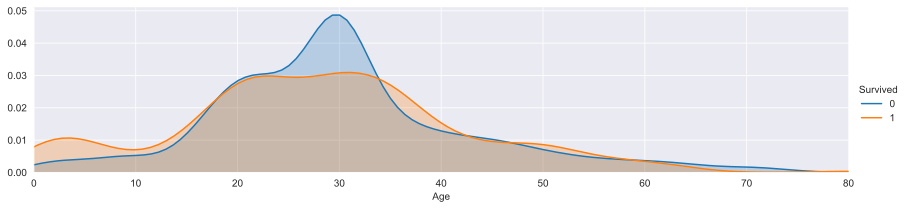

In [222]:
age_dis = sns.FacetGrid(train_data,hue='Survived',aspect=4)
age_dis.map(sns.kdeplot,'Age',shade=True)
age_dis.set(xlim=(0,train_data['Age'].max()))
age_dis.add_legend()

plt.show()

We can detect that there is age arage in which people are more likely to survive. Let's make this as a feature

Let's convert age into numerical values
* group_1 (Age < 18)
* group_2 (18<Age<34)
* group_3 (34<Age<43)
* group_4 (43<Age<47)
* group_5 (47<Age<59)
* group_6 (59<Age=<70)

In [224]:
for idx in merged_data:
    idx.loc[idx['Age']<=18,'Age'] = 0
    idx.loc[(idx['Age']>18) & (idx['Age']<=34),'Age']=1
    idx.loc[(idx['Age']>34) & (idx['Age']<=43),'Age']=2
    idx.loc[(idx['Age']>43) & (idx['Age']<=47),'Age']=3
    idx.loc[(idx['Age']>47) & (idx['Age']<=59),'Age']=4
    idx.loc[(idx['Age']>59) & (idx['Age']<=70),'Age']=5
    idx.loc[(idx['Age']>70) & (idx['Age']<=75),'Age']=6
    idx.loc[(idx['Age']>75) & (idx['Age']<=80),'Age']=7

In [225]:
train_data['Age'] = train_data['Age'].astype(int)
test_data['Age'] = test_data['Age'].astype(int)

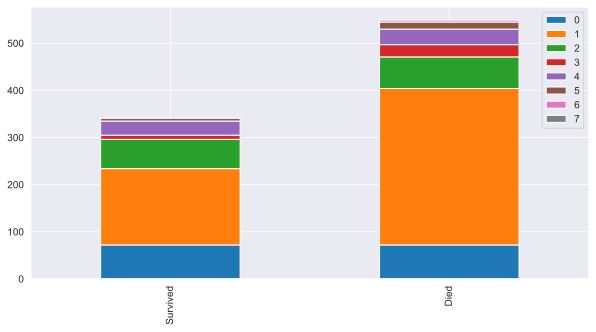

In [226]:
visualise('Age')

### Embarked

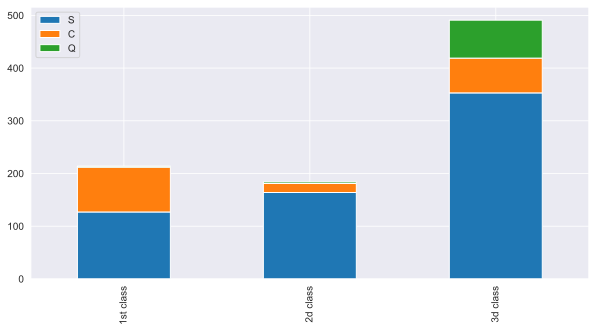

In [227]:
class_1 = train_data.loc[ train_data['Pclass']==1,'Embarked'].value_counts()
class_2 = train_data.loc[ train_data['Pclass']==2,'Embarked'].value_counts()
class_3 = train_data.loc[ train_data['Pclass']==3,'Embarked'].value_counts()

class_df = pd.DataFrame([class_1,class_2,class_3])
class_df.index = ['1st class','2d class','3d class']
class_df.plot(kind='bar',stacked='True',figsize=(10,5))

Can see that most people have embarked from S. Hence, as we have missing values in this column we will fill missing values with S.

In [228]:
embarked_map = {'S':0,'C':1,'Q':2}

for idx in merged_data:
    idx['Embarked'] = idx['Embarked'].fillna('S')

for idx in merged_data:
    idx['Embarked'] = idx['Embarked'].map(embarked_map)

### Fare

In [230]:
test_data['Fare'].fillna(test_data.groupby('Pclass')['Fare'].transform('median'),inplace=True)

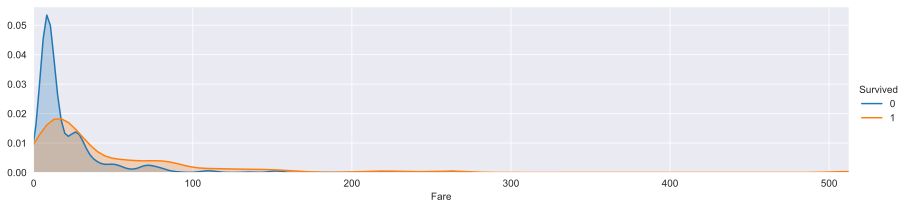

In [231]:
fare_dis = sns.FacetGrid(train_data,hue='Survived',aspect=4)
fare_dis.map(sns.kdeplot,'Fare',shade=True)
fare_dis.set(xlim=(0,train_data['Fare'].max()))
fare_dis.add_legend()

Obvious facat that people who has bought cheap ticket were more likely to be dead

We encode the price as well

In [232]:
for idx in merged_data:
    idx.loc[idx['Fare'] <= 17,'Fare'] = 0
    idx.loc[ (idx['Fare'] > 17) & (idx['Fare'] <= 29),'Fare'] = 1
    idx.loc[ (idx['Fare'] > 29) & (idx['Fare'] <= 100),'Fare'] = 2
    idx.loc[idx['Fare'] > 100 ,'Fare'] = 3

In [233]:
train_data['Fare'] = train_data['Fare'].astype(int)
test_data['Fare'] = test_data['Fare'].astype(int)

### Cabin

In [234]:
for idx in merged_data:
    idx['Cabin'] = idx['Cabin'].str[:1]

In [235]:
train_data['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

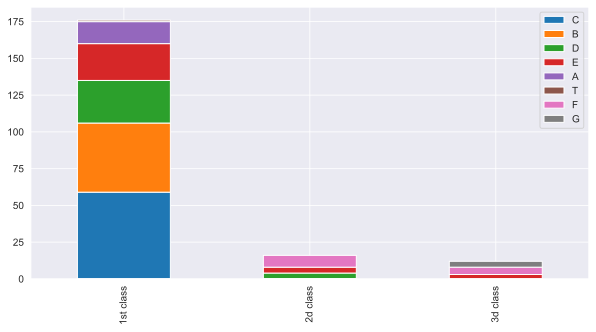

In [236]:
class_1 = train_data.loc[ train_data['Pclass']==1,'Cabin'].value_counts()
class_2 = train_data.loc[ train_data['Pclass']==2,'Cabin'].value_counts()
class_3 = train_data.loc[ train_data['Pclass']==3,'Cabin'].value_counts()

cabin_df = pd.DataFrame([class_1,class_2,class_3])
cabin_df.index = ['1st class','2d class','3d class']
cabin_df.plot(kind='bar',stacked=True,figsize=(10,5))

In [237]:
cabin_map = {'A':0,
             'B':0.4,
             'C':0.8,
             'D':1.2,
             'E':1.6,
             'F':2,
             'G':2.4,
             'T':2.8 }
for idx in merged_data:
    idx['Cabin'] = idx['Cabin'].map(cabin_map)

In [238]:
train_data['Cabin'].fillna(train_data.groupby('Pclass')['Cabin'].transform('median'),inplace=True)
test_data['Cabin'].fillna(test_data.groupby('Pclass')['Cabin'].transform('median'),inplace=True)

In [239]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1,1,0,A/5 21171,0,2.0,0,0
1,2,1,1,1,2,1,0,PC 17599,2,0.8,1,2
2,3,1,3,1,1,0,0,STON/O2. 3101282,0,2.0,0,1
3,4,1,1,1,2,1,0,113803,2,0.8,0,2
4,5,0,3,0,2,0,0,373450,0,2.0,0,0


### Family Size

In [240]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

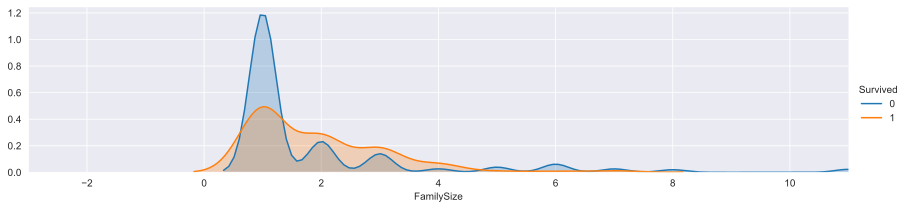

In [241]:
fare_dis = sns.FacetGrid(train_data,hue='Survived',aspect=4)
fare_dis.map(sns.kdeplot,'FamilySize',shade=True)
fare_dis.set(xlim=(-3,train_data['FamilySize'].max()))
fare_dis.add_legend()

In [242]:
family_map ={1:0, 2:0.4, 3:0.8, 4:1.2, 5:1.6, 6:2, 7:2.4, 8:2.8, 11:4}
for idx in merged_data:
    idx['FamilySize'] = idx['FamilySize'].map(family_map)

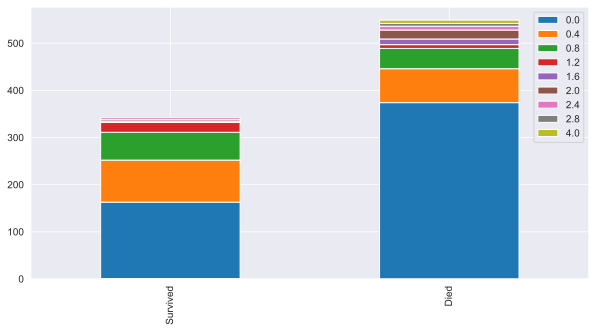

In [243]:
visualise('FamilySize')

In [244]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1,1,0,A/5 21171,0,2.0,0,0,0.4
1,2,1,1,1,2,1,0,PC 17599,2,0.8,1,2,0.4
2,3,1,3,1,1,0,0,STON/O2. 3101282,0,2.0,0,1,0.0
3,4,1,1,1,2,1,0,113803,2,0.8,0,2,0.4
4,5,0,3,0,2,0,0,373450,0,2.0,0,0,0.0


In [245]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2,0,0,330911,0,2.0,2,0,0.0
1,893,3,1,3,1,0,363272,0,2.0,0,2,0.4
2,894,2,0,5,0,0,240276,0,2.0,2,0,0.0
3,895,3,0,1,0,0,315154,0,2.0,0,0,0.0
4,896,3,1,1,1,1,3101298,0,2.0,0,2,0.8


In [246]:
features_to_drop = ['SibSp','Ticket','Parch']
train_data.drop(features_to_drop,axis=1,inplace=True)
test_data.drop(features_to_drop,axis=1,inplace=True)

In [247]:
train_data.drop('PassengerId',axis=1,inplace=True)

In [248]:
train_data.drop('Survived',axis=1)
target = train_data['Survived']

In [249]:
target = train_data['Survived'].copy()
target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [250]:
train_data.drop('Survived',axis=1,inplace=True)

In [251]:
target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

### Models Building 

In [252]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import numpy as np

In [253]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null int32
Fare          891 non-null int32
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null float64
dtypes: float64(2), int32(2), int64(4)
memory usage: 48.9 KB


In [254]:
my_folds = KFold(n_splits=10,shuffle=True,random_state=True)

### kNN

In [255]:
knn_model = KNeighborsClassifier(n_neighbors=13)
knn_score = cross_val_score(knn_model,train_data,target,cv=my_folds,scoring='accuracy')
print(np.mean(knn_score))

0.802521847690387


### Decision Tree

In [256]:
tree = DecisionTreeClassifier()
tree_score = cross_val_score(tree,train_data,target,cv=my_folds,scoring='accuracy')
print(np.mean(tree_score))

0.7935205992509363


### Random Forest

In [257]:
rm_forest = RandomForestClassifier(n_estimators=13)
rm_forest_score = cross_val_score(rm_forest,train_data,target,cv=my_folds,scoring='accuracy')
print(np.mean(rm_forest_score))

0.8148689138576779


### Naive Bayes 

In [258]:
naive_classifier = GaussianNB()
naive_score = cross_val_score(naive_classifier,train_data,target,cv=my_folds,scoring='accuracy')
print(np.mean(naive_score))

0.7767166042446941


### SVM

In [ ]:
passenger_ids = test_data['PassengerId'].copy()
test_data.drop('PassengerId',axis=1,inplace=True)

In [261]:
svm_classifier = SVC()
svm_score = cross_val_score(svm_classifier,train_data,target,cv=my_folds,scoring='accuracy')
print(np.mean(svm_score))

svm_classifier.fit(train_data,target)
predictions = svm_classifier.predict(test_data)

0.8294881398252185


### Submition

In [144]:
sumbission = pd.DataFrame({
    "PassengerId":passenger_ids,
    "Survived":predictions
    })

sumbission.to_csv('submission.csv',index=False)
sumbission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
